# Obstacle Avoidance

This notebook is an extension of our obstacle avoidance lab, demonstrating a simple addition that simulates Frogger more effectively.

In [71]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation

animation.writer = animation.writers['ffmpeg']

The following code is directly from the obstacle avoidance lab, showing how an optimal path is created.

In [3]:
def obstacle(x, y, W1=1, r=(1, 1), c=(0, 0)):
    """
    Define an area that will represent an obstacle
    
    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    """

    ellipse = ((x - c[0])**2/r[0] + (y - c[1])**2/r[1])**20 + 1

    return W1 / ellipse

def obstacle_dx(x, y, W1=1, r=(1, 1,), c=(0, 0)):
    """
    x derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    """

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40 * W1 * (x-c[0])*(circle)**19
    denom = r[0]*((circle)**20 + 1)**2

    return numer / denom

def obstacle_dy(x, y, W1=1, r=(1, 1,), c=(0, 0)):
    """
    y derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    """

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40 * W1 * (y-c[1])*(circle)**19
    denom = r[1]*((circle)**20 + 1)**2

    return numer / denom

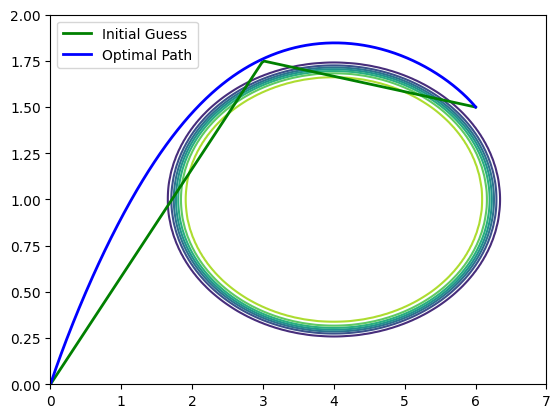

In [4]:
def avoid_obstacle():
    """
    Find the optimal path for the fixed time horizon problem
    """
    # Define the parameters for the system
    W1 = 3
    W2 = 70
    r = (5, 0.5)
    c = (4, 1)
    
    # Define the ODE for the system
    def ode(t, y):
        return np.array([
            y[2],
            y[3],
            y[6] / (2 * W2),
            y[7] / (2 * W2),
            obstacle_dx(y[0], y[1], W1, r, c),
            obstacle_dy(y[0], y[1], W1, r, c),
            -y[4],
            -y[5]
        ])
    
    # Define the boundary conditions
    def bc(ya, yb):
        return np.array([
            ya[0] - 6,
            ya[1] - 1.5,
            ya[2],
            ya[3],
            yb[0],
            yb[1],
            yb[2],
            yb[3]
        ])
    
    # Define the initial guess
    t_steps = 200
    t_eval = np.linspace(0, 20, t_steps)
    y0 = np.ones((8, t_steps))
    x = np.linspace(0, 6, t_steps)
    y1 = (1.75 / 3) * x[:int(t_steps / 2)]
    y2 = (1.5 - 1.75) / 3 * (x[int(t_steps / 2):] - 3) + 1.75
    y_init = np.concatenate((y1, y2))
    y0[0, :] = x[::-1]
    y0[1, :] = y_init[::-1]
    y0[2, :] = -1 * np.ones(t_steps)
    
    # Solve the ODE
    sol = solve_bvp(ode, bc, t_eval, y0, max_nodes=30000)
    
    # Plot the obstacle
    X, Y = np.meshgrid(np.linspace(0, 7, 200), np.linspace(0, 2, 200))
    plt.contour(X, Y, obstacle(X, Y, W1, r, c))
    
    # Plot the solution
    plt.plot(y0[0], y0[1], c='green', linewidth=2, label='Initial Guess')
    plt.plot(sol.y[0], sol.y[1], c='blue', linewidth=2, label='Optimal Path')
    plt.legend()
    
    plt.show()
    
avoid_obstacle()

## Multiple Obstacles
Next, we try adding multiple static obstacles. These obstacles don't move, and they're smaller than the previous obstacles.

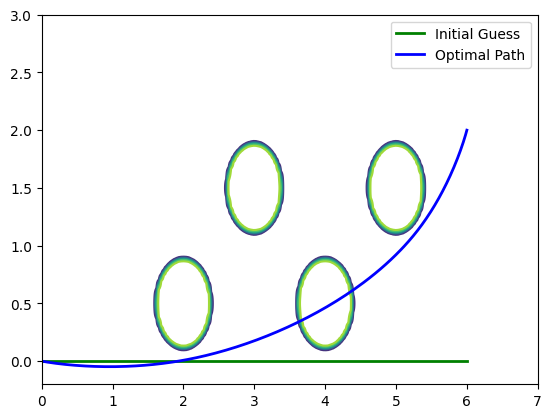

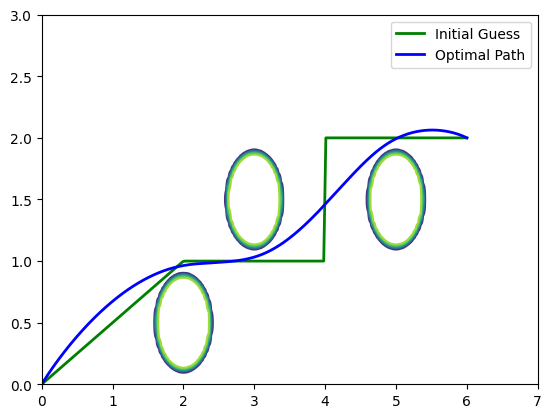

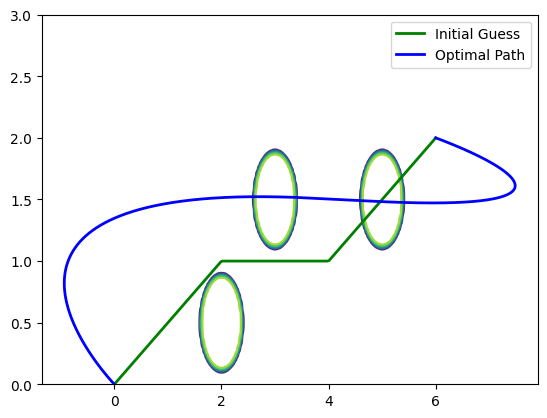

In [67]:
def many_obstacles(r, c, f0):
    # Define the weights (same)
    W1 = 100
    W2 = 20
    
    # Define the ODE
    def ode(t, y):
        return np.array([
            y[2],
            y[3],
            y[6] / (2 * W2),
            y[7] / (2 * W2),
            sum(obstacle_dx(y[0], y[1], W1, r[i], c[i]) for i in range(3)), # Sums over all the ellipses
            sum(obstacle_dy(y[0], y[1], W1, r[i], c[i]) for i in range(3)),
            -y[4],
            -y[5]
        ])
    
    # Define the boundary conditions (same)
    def bc(ya, yb):
        return np.array([
            ya[0] - 6,
            ya[1] - 2,
            ya[2],
            ya[3],
            yb[0],
            yb[1],
            yb[2],
            yb[3]
        ])
    
    # Define the initial guess
    t_steps = 200
    t_eval = np.linspace(0, 20, t_steps)
    y0 = np.zeros((8, t_steps))
    x = np.linspace(0, 6, t_steps)
    y0[0, :] = x[::-1]
    y0[1, :] = f(x)[::-1]
    y0[2, :] = -1 * np.ones(t_steps)
    
    # Solve the ODE
    sol = solve_bvp(ode, bc, t_eval, y0, max_nodes=30000)
    
    # Plot the obstacle
    X, Y = np.meshgrid(np.linspace(0, 7, 200), np.linspace(0, 3, 200))
    for i in range(len(r)):
        plt.contour(X, Y, obstacle(X, Y, W1, r[i], c[i]))
        
    # Plot the solution
    plt.plot(y0[0], y0[1], c='green', linewidth=2, label='Initial Guess')
    plt.plot(sol.y[0], sol.y[1], c='blue', linewidth=2, label='Optimal Path')
    plt.legend()
    
    plt.show()
    
# Set multiple obstacles
r = [(0.15, 0.15), (0.15, 0.15), (0.15, 0.15), (0.15, 0.15)]        # Multiple sets of radii
c = [(2, 0.5), (3, 1.5), (5, 1.5), (4, 0.5)]   # Multiple Centers

def f(x_):
    return 0 * x_

many_obstacles(r, c, f)

# Second
r = [(0.15, 0.15), (0.15, 0.15), (0.15, 0.15)]
c = [(2, 0.5), (3, 1.5), (5, 1.5)]

def f(x_):
    return (x_ / 2) * (x_ <= 2) + 1 * (2 < x_) * (x_ <= 4) + 2 * (4 < x_) #+ (x_ - 2) * (3 < x_) * (x_ < 4)

many_obstacles(r, c, f)

def f(x_):
    return (x_ / 2) * (x_ <= 2) + 1 * (2 < x_) * (x_ <= 4) + (x_ / 2 - 1) * (4 < x_)

many_obstacles(r, c, f)

Lessons learned from this:
- The initial guess is absolutely critical. If the initial guess passes through the obstacle, crap hits the fan. This will make things really difficult when making moving obstacles.
- Also, it's hard to tune the weights to do what we want.

## Moving Obstacles

Now, we experiment making one obstacle time-dependent and move with time. To do this, we definea new `obstacle` function that includes a time parameter, and have the centers each be functions of time.

In [68]:
def moving_obstacle(t, x, y, W1=1, r=(1, 1), c=(0, 0)):
    """
    Define an area that will represent an obstacle
    
    Parameters:
        t (float): time
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple of functions): center of the ellipse
    """

    ellipse = ((x - c[0](t))**2/r[0] + (y - c[1](t))**2/r[1])**20 + 1

    return W1 / ellipse

def moving_obstacle_dx(t, x, y, W1=1, r=(1, 1,), c=(0, 0)):
    """
    x derivative of the obstacle

    Parameters:
        t (float): time
        x (float): x position in space
        y (float): y position in space
        W (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    """

    circle = (x - c[0](t))**2/r[0] + (y - c[1](t))**2/r[1]
    numer = -40 * W1 * (x-c[0](t))*(circle)**19
    denom = r[0]*((circle)**20 + 1)**2

    return numer / denom

def moving_obstacle_dy(t, x, y, W1=1, r=(1, 1,), c=(0, 0)):
    """
    y derivative of the obstacle

    Parameters:
        t (float): time
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    """

    circle = (x - c[0](t))**2/r[0] + (y - c[1](t))**2/r[1]
    numer = -40 * W1 * (y-c[1](t))*(circle)**19
    denom = r[1]*((circle)**20 + 1)**2

    return numer / denom

In this case, we have the obstacle move from $y = 0$ to $y = 3$, looping repeatedly with the functional form $f(t) = t \text{ mod } 3$. This behavior will allow us to reduce the number of obstacles by having obstacles start back at the beginning rather than needing to create new obstacles once the obstacles previously created have passed to the end of the frame.

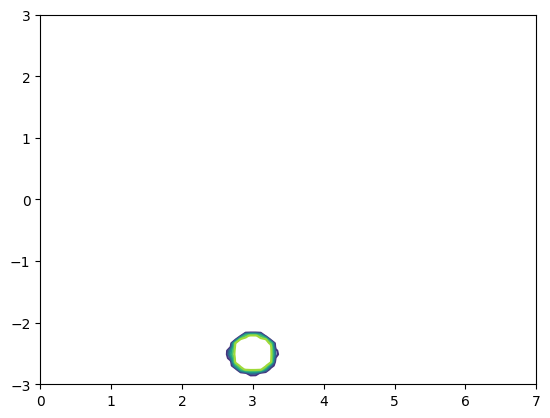

In [87]:
c = (lambda t: 3, lambda t: t % 5 - 2.5) 

fig, ax = plt.subplots()
x = np.linspace(0, 7, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)


contour = ax.contour(X, Y, moving_obstacle(0, X, Y, r=(0.1, 0.1), c=c))

def update(t):
    ax.clear()
    contour = ax.contour(X, Y, moving_obstacle(t, X, Y, r=(0.1, 0.1), c=c))
    return contour

ani = FuncAnimation(fig, update, frames=np.linspace(0, 10, 100), interval=50)

ani.save("moving_obstacle_animation.mp4")

## Avoiding One Moving Obstacle

The next step is trying to navigate to the end while avoiding the moving obstacle.

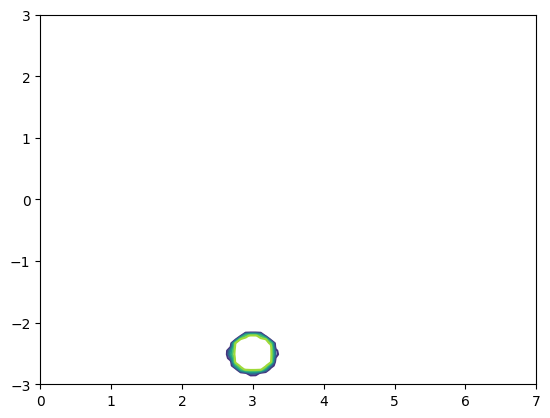

In [89]:
def avoid_moving_obstacle(r, c):
    """
    Find the optimal path for the fixed time horizon problem
    """
    # Define the parameters for the system
    W1 = 100
    W2 = 10
    
    # Define the ODE for the system
    def ode(t, y):
        return np.array([
            y[2],
            y[3],
            y[6] / (2 * W2),
            y[7] / (2 * W2),
            moving_obstacle_dx(t, y[0], y[1], W1, r, c),
            moving_obstacle_dy(t, y[0], y[1], W1, r, c),
            -y[4],
            -y[5]
        ])
    
    # Define the boundary conditions
    def bc(ya, yb):
        return np.array([
            ya[0] - 6,
            ya[1],
            ya[2],
            ya[3],
            yb[0],
            yb[1],
            yb[2],
            yb[3]
        ])
    
    # Define the initial guess
    t_steps = 200
    t_eval = np.linspace(0, 20, t_steps)
    y0 = np.ones((8, t_steps))
    x = np.linspace(0, 6, t_steps)
    y1 = (1.75 / 3) * x[:int(t_steps / 2)]
    y2 = (- 1.75) / 3 * (x[int(t_steps / 2):] - 3) + 1.75
    y_init = np.concatenate((y1, y2))
    y0[0, :] = x[::-1]
    y0[1, :] = y_init[::-1]
    y0[2, :] = -1 * np.ones(t_steps)
    
    # Solve the ODE
    sol = solve_bvp(ode, bc, t_eval, y0, max_nodes=30000)
    
    # Plot the obstacle
    fig, ax = plt.subplots()
    x = np.linspace(0, 7, 100)
    y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    
    ax.plot(y0[1], y0[2], label='Initial Guess')
    
    def animate(t):
        ax.clear()
        contour = ax.contour(X, Y, moving_obstacle(t, X, Y, r=r, c=c))
        line = ax.plot(*sol.sol(np.linspace(0, t, 200))[:2, :])
        return contour, line
        
    ani = FuncAnimation(fig, animate, frames=t_eval, interval=50)
    
    ani.save("avoiding_moving_object.mp4")
    
avoid_moving_obstacle((0.1, 0.1), c)

Issues with this:
- The movement is back to front, meaning it's starting at the endpoint and moving back to the origin.
- It definitely gets hit by the obstacle. Not sure why it doesn't move a little bit faster, since the speed clearly changes throughout.

## Avoiding Many Moving Obstacles

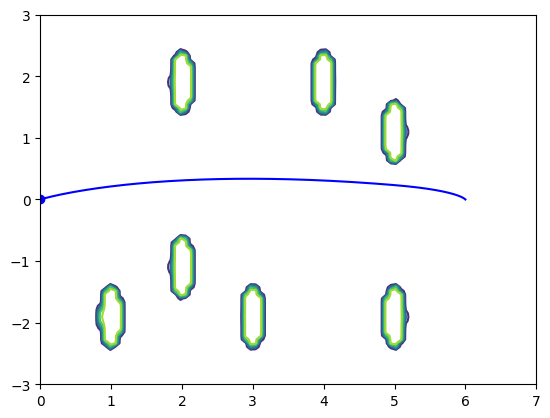

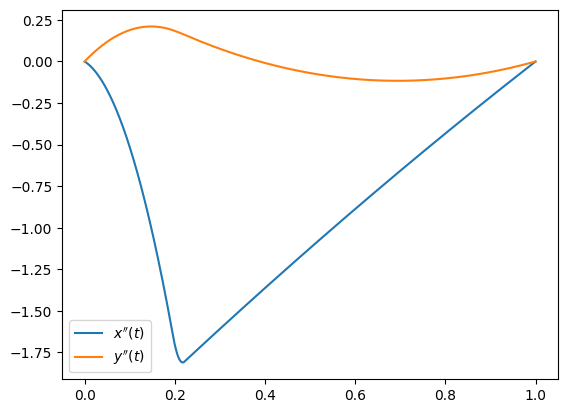

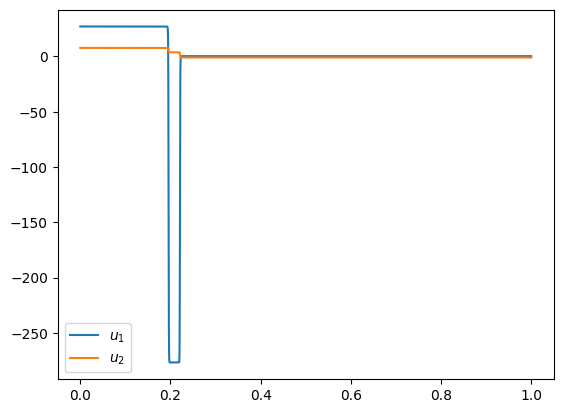

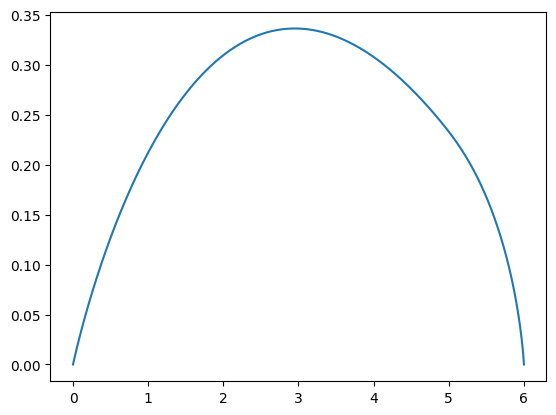

Time taken to reach the end: 7.095949034572132


In [162]:
def avoid_many_moving_obstacle(r, c):
    """
    Find the optimal path for the fixed time horizon problem
    """
    # Define the parameters for the system
    W1 = 500
    W2 = 10
    
    # Define the ODE for the system
    def ode(t, y, p):
        return p[0] * np.array([
            y[2],
            y[3],
            y[6] / (2 * W2),
            y[7] / (2 * W2),
            sum(moving_obstacle_dx(t, y[0], y[1], W1, r[i], c[i]) for i in range(len(c))), # Sums over all the ellipses
            sum(moving_obstacle_dy(t, y[0], y[1], W1, r[i], c[i]) for i in range(len(c))),
            -y[4],
            -y[5]
        ])
    
    # Define the boundary conditions
    def bc(ya, yb, p):
        utf = yb[6:] / (2 * W2)
        return np.array([
            ya[0] - 6,
            ya[1],
            ya[2],
            ya[3],
            yb[0],
            yb[1],
            yb[2],
            yb[3],
            yb[2:4] @ yb[4:6] + yb[6:] @ utf - (1 + sum(moving_obstacle(p[0], yb[0], yb[1], W1, r[i], c[i]) for i in range(len(c))) + W2 * (utf**2).sum())
        ])
    
    # Define the initial guess
    t_steps = 200
    t_eval = np.linspace(0, 1, t_steps)
    y0 = np.zeros((8, t_steps))
    x = np.linspace(0, 6, t_steps)
    y1 = (1.75 / 3) * x[:int(t_steps / 2)]
    y2 = (- 1.75) / 3 * (x[int(t_steps / 2):] - 3) + 1.75
    y_init = np.concatenate((y1, y2))
    y0[0, :] = x[::-1]
    y0[1, :] = y_init[::-1]
    y0[2, :] = -1 * np.ones(t_steps)
    
    p0 = np.array([6.0])
    
    # Solve the ODE
    sol = solve_bvp(ode, bc, t_eval, y0, p0, max_nodes=30000)
    
    # Plot the obstacle
    fig, ax = plt.subplots()
    x = np.linspace(0, 7, 100)
    y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    
    ax.plot(y0[1], y0[2], label='Initial Guess')
    
    def animate(t):
        ax.clear()
        contour = []
        for i in range(len(c)):
            contour.append(ax.contour(X, Y, moving_obstacle(t, X, Y, r=r[i], c=c[i])))
        line = ax.plot(*sol.sol(np.linspace(0, t / sol.p[0], 200))[:2, :], c='blue')
        dot = ax.plot(*sol.sol(t / sol.p[0])[:2], 'o', c='blue')
        return *contour, line, dot
        
    ani = FuncAnimation(fig, animate, frames=np.linspace(0, sol.p[0], 20 * np.ceil(sol.p[0]).astype(int)), interval=50)
    
    ani.save("avoiding_many_moving_object.mp4")
    plt.show()
    
    plt.plot(sol.x, sol.y[2], label="$x'(t)$")
    plt.plot(sol.x, sol.y[3], label="$y'(t)$")
    plt.legend()
    plt.show()
    
    plt.plot(sol.x, sol.y[4], label='$u_1$')
    plt.plot(sol.x, sol.y[5], label='$u_2$')
    plt.legend()
    plt.show()
    
    plt.plot(*sol.y[:2, :])
    plt.show()
    
    print("Time taken to reach the end:", sol.p[0])
    
c = [
    (lambda t: 1, lambda t: t % 6 - 3),
    (lambda t: 2, lambda t: -(t % 6) + 3),
    (lambda t: 2, lambda t: -((t + 3) % 6) + 3),
    (lambda t: 3, lambda t: t % 6 - 3),
    (lambda t: 4, lambda t: -(t % 6) + 3),
    (lambda t: 5, lambda t: t % 6 - 3),
    (lambda t: 5, lambda t: (t + 3) % 6 - 3)
]
r = np.array([
    (0.1, 1),
    (0.1, 1),
    (0.1, 1),
    (0.1, 1),
    (0.1, 1),
    (0.1, 1),
    (0.1, 1)
])/4

avoid_many_moving_obstacle(r, c)